## What's your city

In [1]:
# run code colab
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *

## Get data

Go to [Google Images](http://images.google.com) and search for the images you are interested in.

It is a good idea to put things you want to exclude into the search query:

    "san francisco" -munich -seoul

And you can also limit your results to show `only photos` by clicking on Settings and Advanced Search.

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
def download_img(city: str):
    folder = city
    file = f'{city}.csv'
    path = Path('./data')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=200)
    verify_images(path/city, delete=True, max_size=500)

In [0]:
download_img('sanfrancisco')
download_img('munich')
download_img('seoul')

In [0]:
classes = ['sanfrancisco','munich','seoul']

## View data

In [0]:
ImageDataBunch()

In [0]:
np.random.seed(0)
path = Path('./data')
data = ImageDataBunch.from_folder(path, train="./dataset", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [14]:
data.classes

['munich', 'sanfrancisco', 'seoul']

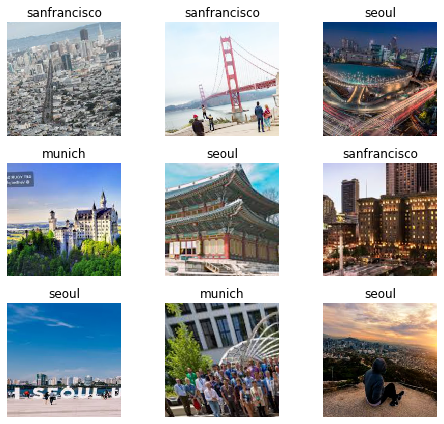

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
data.c, len(data.train_ds), len(data.valid_ds) #class, train, validation

(3, 384, 96)

## Train model

In [0]:
dir(models)

In [0]:
# usisng resnet34 as pre-trained model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

#### Fine-tuning (with resnet36)

In [18]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


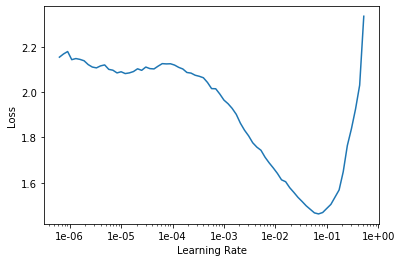

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.973861,2.080245,0.385417,00:05
1,1.548100,3.357084,0.437500,00:05
2,1.270353,1.666839,0.375000,00:05
3,1.097448,1.420140,0.343750,00:05


In [0]:
learn.save('stage-1')

### train the whole model

In [31]:
# del learn
import gc
gc.collect()

7773

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.20E-04


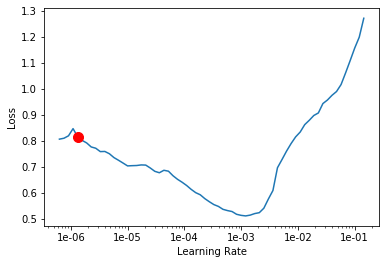

In [37]:
learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(4, max_lr = slice(1e-04,1e-2/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.815242,1.545236,0.375000,00:05
1,0.706438,2.107143,0.416667,00:05
2,0.609808,1.615374,0.302083,00:05
3,0.529277,1.256467,0.291667,00:05


In [0]:
learn.save('stage-2')

### Going bigger

In [0]:
data = ImageDataBunch.from_folder(path, train="./dataset", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=128).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).load('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


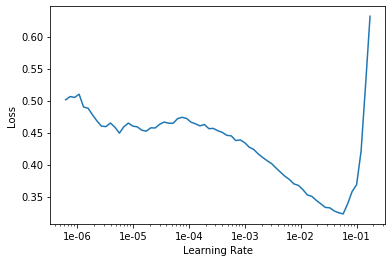

In [43]:
 lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-3

In [45]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.482694,0.123418,0.031250,00:06
1,0.472738,0.112043,0.020833,00:05
2,0.417268,0.110537,0.020833,00:05


In [0]:
learn.save('stage-bigger')

## Interpretation

In [0]:
learn.load('stage-bigger');

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

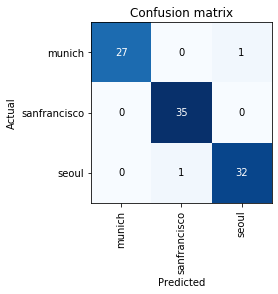

In [50]:
interp.plot_confusion_matrix()

In [51]:
interp.most_confused()

[('munich', 'seoul', 1), ('seoul', 'sanfrancisco', 1)]

### Data Cleaning

* ImageCleaner does not work in Colab. Use this method instead
    - https://forums.fast.ai/t/platform-colab/28161/184
    - https://forums.fast.ai/t/pr-new-widget-class-confusion-with-google-colab-support/50829

In [0]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset **without the split**. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [0]:
ImageList.from_folder(path)

ImageList (480 items)
Image (3, 168, 300),Image (3, 225, 225),Image (3, 194, 259),Image (3, 159, 318),Image (3, 127, 397)
Path: dataset

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch())

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
cleaner_tuples = []
for ds_type in [DatasetType.Valid, DatasetType.Train]:
  ds, idxs = DatasetFormatter().from_toplosses(learn, n_imgs=30, ds_type=ds_type)
  cleaner_tuples.append((ds_type, ds, idxs))

import ntpath

top_loss_path = path/'top_losses/'
top_loss_path.mkdir(parents=True, exist_ok=True)
top_loss_filenames = set()

for ct in cleaner_tuples:
  ds_type = ct[0]
  ds = ct[1]
  idxs = ct[2]

  for idx in idxs:
    full_filepath = ds.x.items[idx]
    _, filename = ntpath.split(full_filepath)
    
    image_data = ds[idx][0]
    image_category = ds[idx][1]
    image_fullpath = top_loss_path/f'{image_category}_{filename}'
    image_data.save(image_fullpath)
    top_loss_filenames.add(image_fullpath) 
    
print(f'{len(top_loss_filenames)} top loss images saved to {top_loss_path}')

46 top loss images saved to dataset/top_losses


In [0]:
doc(data.show_batch)

## Model in production

In [0]:
learn.export()

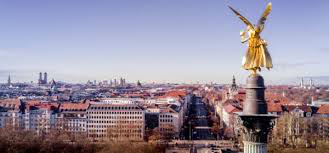

In [53]:
img = open_image(path/'munich'/'00000021.jpg')
img

you can test the model

In [0]:
learn = load_learner(path)

In [55]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category munich